In [13]:
import bargo.engine as engine

import os
import numpy as np
from scipy.special import jn, jn_zeros
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42
matplotlib.rcParams['font.family'] = 'serif'

from sklearn.metrics import r2_score

import pickle

In [14]:
run = 'run0'
N = 100
metric_path = f'data/{run}/N{N}'
h = 2 / (N - 1)

with open(os.path.join(metric_path, 'mask.pkl'), 'rb') as file:
    mask = pickle.load(file)
with open(os.path.join(metric_path, 'metricized_grid.pkl'), 'rb') as file:
    Y, Js, dJs = pickle.load(file)

Gs_inv, Ws = engine.cast_metric(Js, dJs)

In [15]:
n = 1
k = 2

def l(n, k):
    return jn_zeros(n, k)[-1]

def f(x, y):
    r = np.sqrt(x**2 + y**2)
    p = np.arctan2(y, x)
    return jn(n, l(n, k) * r) * np.cos(n * p)

def FVU(y_true, y_pred):
    return 1 - r2_score(y_true, y_pred)

In [16]:
solver = engine.FDSolver(Y, mask, Gs_inv, Ws, h, f, [1], 'helmholtz')

In [17]:
L = solver.get_fd_matrix()
b = solver.get_rhs()

In [18]:
u = np.linalg.inv(L) @ b

In [19]:
u_exact = b / (1 - l(n, k)**2)

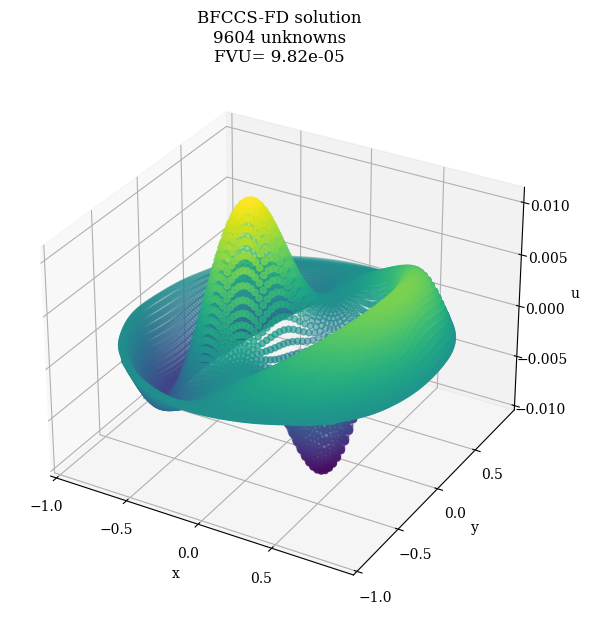

In [20]:
fig, ax = solver.plot(u)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
ax.set_zlim((-0.01, 0.011))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')

ax.xaxis.set_ticks(np.arange(*ax.get_xlim(), 0.5))
ax.yaxis.set_ticks(np.arange(*ax.get_ylim(), 0.5))
ax.zaxis.set_ticks(np.arange(*ax.get_zlim(), 0.005))

ax.set_title(f'BFCCS-FD solution\n{mask.sum()} unknowns\nFVU={FVU(u_exact, u): .2e}')
plt.savefig(os.path.join(metric_path, 'bfccs_solution.png'))
plt.show()

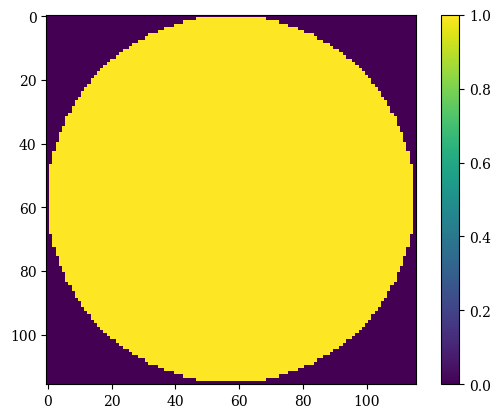

In [21]:
Nsq = np.ceil(np.sqrt(4 / np.pi) * (N - 1)).astype(int) + 4
hsq = 2 / (Nsq - 1)
x0 = -1
y0 = -1

mask = np.zeros((Nsq, Nsq), dtype=int)
Y = []
for i in range(Nsq):
    for j in range(Nsq):
        x = x0 + i * hsq
        y = y0 + j * hsq
        Y.append([x, y])
        if x**2 + y**2 < 1:
            mask[i, j] = 1

Y = np.array(Y)

plt.imshow(mask)
plt.colorbar()

In [22]:
N = len(Y)
Gs_inv = np.array([np.identity(2) for _ in range(N)])
Ws = np.zeros((N, 2, 2, 2))

solver = engine.FDSolver(Y, mask, Gs_inv, Ws, hsq, f, [1], 'helmholtz')

In [23]:
L = solver.get_fd_matrix()
b = solver.get_rhs()
u = np.linalg.inv(L) @ b
u_exact = [f(*pt) / (1 - l(n, k)**2) for pt in Y[mask.flatten().astype(bool)]]

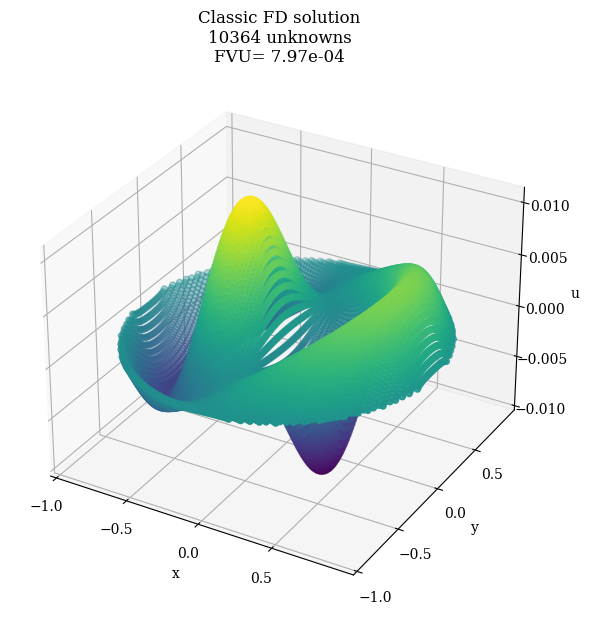

In [24]:
fig, ax = solver.plot(u)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
ax.set_zlim((-0.01, 0.011))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')

ax.xaxis.set_ticks(np.arange(*ax.get_xlim(), 0.5))
ax.yaxis.set_ticks(np.arange(*ax.get_ylim(), 0.5))
ax.zaxis.set_ticks(np.arange(*ax.get_zlim(), 0.005))

ax.set_title(f'Classic FD solution\n{mask.sum()} unknowns\nFVU={FVU(u_exact, u): .2e}')
plt.savefig(os.path.join(metric_path, 'classic_solution.png'))
plt.show()